# Define the imports

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objs as go
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from statsmodels.graphics.tsaplots import plot_acf
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS

warnings.filterwarnings('ignore')
seed_value = 123

In [2]:
energy_production = pd.read_csv('./solar_data/Solar_Energy_Production.csv')
energy_production_sites = pd.read_csv('./solar_data/Solar_Photovoltaic_Sites.csv')

In [3]:
energy_production.head()

,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 08:00:00 AM,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 09:00:00 AM,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 10:00:00 AM,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 11:00:00 AM,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 12:00:00 PM,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


In [4]:
energy_production_sites.head()

,id,name,address_orig,address,latitude,longitude,location,installationDate,public_url,manufacturerName,modelName,maximumPower,City Quadrants,Ward Boundaries,Calgary Communities
0,NaN,Municipal Building,800 MacLeod TR SE,800 MACLEOD TR SE,51.045414,-114.056546,"(51.04541403, -114.0565464)",2008/01/01,NaN,NaN,NaN,NaN,3,7,262
1,NaN,Fire Station No. 30 - McKenzie Towne,6 McKenzie Towne GA SE,6 MCKENZIE TOWNE GA SE,50.916432,-113.963070,"(50.91643163, -113.963069726759)",2010/01/01,NaN,NaN,NaN,NaN,3,4,46
2,NaN,Ralph Klein Legacy Park,12350 84 ST SE,12350 84 ST SE,50.937563,-113.903017,"(50.93756317, -113.9030174)",2010/01/01,NaN,NaN,NaN,NaN,3,4,211
3,NaN,Fire Station No. 8 – Rosscarrock,1720 45 ST SW,1720 45 ST SW,51.038673,-114.152118,"(51.03867255, -114.1521183)",2011/01/01,NaN,NaN,NaN,NaN,1,14,281
4,NaN,Fire Station No. 22 - Temple,7199 Temple DR NW,7199 TEMPLE DR NE,51.091770,-113.957493,"(51.09177006, -113.9574929)",2011/01/01,NaN,NaN,NaN,NaN,4,9,22


In [5]:
nulls_sites = pd.DataFrame(energy_production_sites.isnull().mean() * 100, columns=['percentage_of_nulls'])
nulls_sites

,percentage_of_nulls
id,47.619048
name,0.000000
address_orig,0.000000
address,0.000000
latitude,0.000000
longitude,0.000000
location,0.000000
installationDate,4.761905
public_url,47.619048
manufacturerName,47.619048


In [6]:
nulls_energy = pd.DataFrame(energy_production.isnull().mean() * 100, columns=['percentage_of_nulls'])
nulls_energy

,percentage_of_nulls
name,0.0
id,0.0
address,0.0
date,0.0
kWh,0.0
public_url,0.0
installationDate,0.0
uid,0.0


In [7]:
energy_production.groupby('id')['name'].agg(lambda x: ', '.join(set(x)))

id
164440                     Southland Leisure Centre
308057    Hillhurst Sunnyside Community Association
314106               Calgary Fire Hall Headquarters
319086               Whitehorn Multi-Service Centre
331901    City of Calgary North Corporate Warehouse
332785          Richmond - Knob Hill Community Hall
355827               Glenmore Water Treatment Plant
551172                              CFD Firehall #7
570079                        Manchester Building M
577650               Bearspaw Water Treatment Plant
594148                                  Telus Spark
Name: name, dtype: object

In [8]:
energy_production_sites.groupby('id')['name'].agg(lambda x: ', '.join(set(x)))

id
164440.0                     Southland Leisure Centre
308057.0    Hillhurst Sunnyside Community Association
314106.0               Calgary Fire Hall Headquarters
319086.0               Whitehorn Multi-Service Centre
331901.0    City of Calgary North Corporate Warehouse
332785.0          Richmond - Knob Hill Community Hall
355827.0               Glenmore Water Treatment Plant
551172.0                              CFD Firehall #7
570079.0                        Manchester Building M
577650.0        CoC Bearspaw Water Treatment Plant PV
594148.0                                  Telus Spark
Name: name, dtype: object

In [9]:
array2 = set(energy_production['id'].unique())
array1 = set(energy_production_sites['id'].unique())
same_elements = set(array1) - set(array2)
same_elements

{nan}

In [10]:
weather = pd.read_csv('./weather.csv', sep=',')

In [11]:
weather.head(10)

,Unnamed: 0,name,id,address,date,GHI,latitude,longitude,time,surface_pressure,...,winddirection_10m,relativehumidity_2m,windgusts_10m,windspeed_10m,precipitation,cloudcover,elevation,timezone,sunrise,sunset
0,0,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-21 10:45:00,0.970,51.10499,-114.250011,2017-11-21 10:45:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-21 11:45:00,23.927,51.10499,-114.250011,2017-11-21 11:45:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-21 12:45:00,69.659,51.10499,-114.250011,2017-11-21 12:45:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-21 13:45:00,59.172,51.10499,-114.250011,2017-11-21 13:45:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-21 14:45:00,18.061,51.10499,-114.250011,2017-11-21 14:45:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-22 08:45:00,12.285,51.10499,-114.250011,2017-11-22 08:45:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-22 09:00:00,20.961,51.10499,-114.250011,2017-11-22 09:00:00,884.2,...,274.0,71.0,19.9,6.5,0.0,0.0,1088.0,MDT,2017-11-22T09:05,2017-11-22T17:40
7,7,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-22 09:45:00,42.792,51.10499,-114.250011,2017-11-22 09:45:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-22 10:00:00,50.230,51.10499,-114.250011,2017-11-22 10:00:00,883.8,...,201.0,89.0,11.9,3.1,0.0,0.0,1088.0,MDT,2017-11-22T09:05,2017-11-22T17:40
9,9,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-22 10:45:00,166.551,51.10499,-114.250011,2017-11-22 10:45:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
weather.isna().sum()

Unnamed: 0               0
name                     0
id                       0
address                  0
date                     0
GHI                      0
latitude                 0
longitude                0
time                     0
surface_pressure       336
snowfall               336
temperature_2m         336
winddirection_10m      336
relativehumidity_2m    336
windgusts_10m          336
windspeed_10m          336
precipitation          336
cloudcover             336
elevation              336
timezone               336
sunrise                336
sunset                 336
dtype: int64

In [39]:
weather_cleared = weather.dropna()

weather_cleared['date'] = pd.to_datetime(weather_cleared['date'])

weather_cleared.isna().sum()

Unnamed: 0             0
name                   0
id                     0
address                0
date                   0
GHI                    0
latitude               0
longitude              0
time                   0
surface_pressure       0
snowfall               0
temperature_2m         0
winddirection_10m      0
relativehumidity_2m    0
windgusts_10m          0
windspeed_10m          0
precipitation          0
cloudcover             0
elevation              0
timezone               0
sunrise                0
sunset                 0
dtype: int64

In [40]:
weather_cleared.head(5)

,Unnamed: 0,name,id,address,date,GHI,latitude,longitude,time,surface_pressure,...,winddirection_10m,relativehumidity_2m,windgusts_10m,windspeed_10m,precipitation,cloudcover,elevation,timezone,sunrise,sunset
6,6,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-22 09:00:00,20.961,51.10499,-114.250011,2017-11-22 09:00:00,884.2,...,274.0,71.0,19.9,6.5,0.0,0.0,1088.0,MDT,2017-11-22T09:05,2017-11-22T17:40
8,8,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-22 10:00:00,50.230,51.10499,-114.250011,2017-11-22 10:00:00,883.8,...,201.0,89.0,11.9,3.1,0.0,0.0,1088.0,MDT,2017-11-22T09:05,2017-11-22T17:40
10,10,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-22 11:00:00,236.600,51.10499,-114.250011,2017-11-22 11:00:00,884.3,...,173.0,87.0,8.9,3.6,0.0,3.0,1088.0,MDT,2017-11-22T09:05,2017-11-22T17:40
12,12,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-22 12:00:00,399.535,51.10499,-114.250011,2017-11-22 12:00:00,884.3,...,124.0,84.0,8.3,4.0,0.0,2.0,1088.0,MDT,2017-11-22T09:05,2017-11-22T17:40
14,14,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017-11-22 13:00:00,398.994,51.10499,-114.250011,2017-11-22 13:00:00,884.4,...,118.0,80.0,7.6,4.3,0.0,2.0,1088.0,MDT,2017-11-22T09:05,2017-11-22T17:40


In [41]:
columns_to_convert = ['surface_pressure', 'temperature_2m', 'winddirection_10m', 
                      'relativehumidity_2m', 'windgusts_10m', 'windspeed_10m', 
                      'precipitation', 'cloudcover']

weather_cleared_num = weather_cleared
weather_cleared_num[columns_to_convert] = weather_cleared_num[columns_to_convert].apply(pd.to_numeric, errors='coerce')
weather_cleared_num = weather_cleared_num.select_dtypes(include='number')
weather_cleared_num = weather_cleared_num.drop('id', axis=1)
weather_cleared_num = weather_cleared_num.drop('Unnamed: 0', axis=1)
weather_cleared_num = weather_cleared_num.drop('latitude', axis=1)
weather_cleared_num = weather_cleared_num.drop('longitude', axis=1)
weather_cleared_num = weather_cleared_num.drop('elevation', axis=1)

weather_cleared_num.dtypes


GHI                    float64
surface_pressure       float64
snowfall               float64
temperature_2m         float64
winddirection_10m      float64
relativehumidity_2m    float64
windgusts_10m          float64
windspeed_10m          float64
precipitation          float64
cloudcover             float64
dtype: object

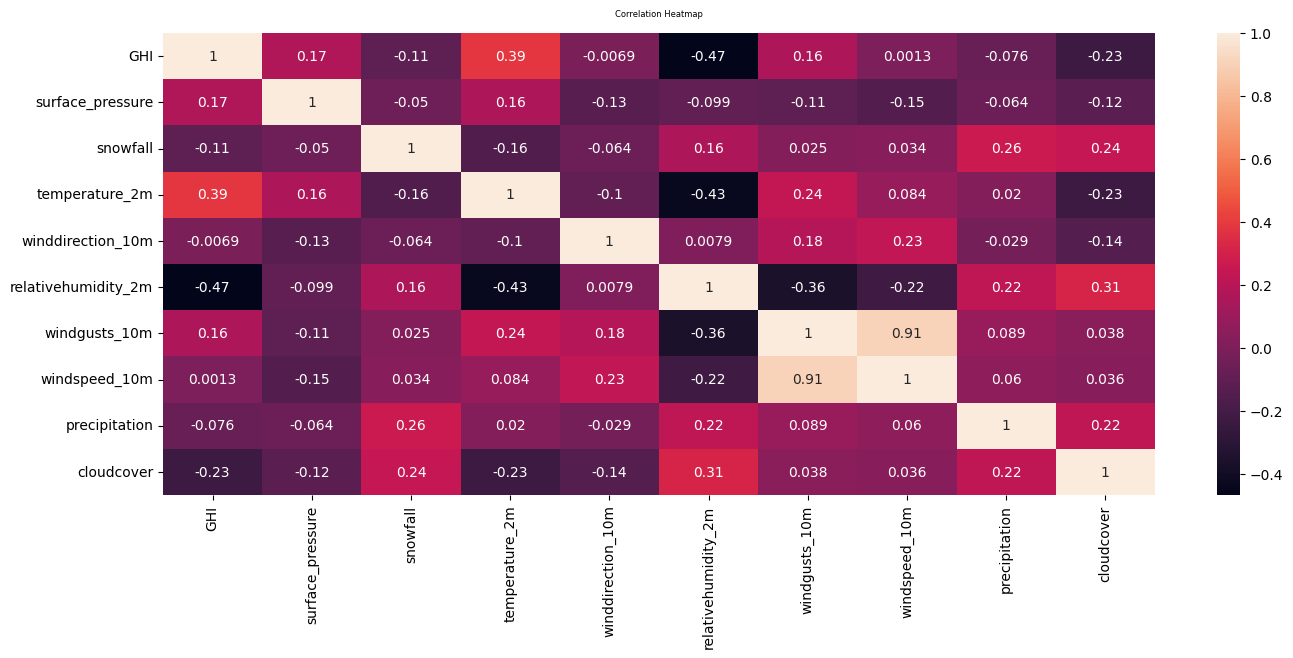

In [42]:
plt.figure(figsize=(16, 6))

heat = sns.heatmap(weather_cleared_num.corr(), annot=True);
heat.set_title('Correlation Heatmap', fontdict={'fontsize':6}, pad=12);

In [43]:
df_daily_avg = weather_cleared.groupby('date').agg({
    'temperature_2m': 'mean',
    'GHI': 'mean'
}).reset_index()
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_daily_avg['date'], y=df_daily_avg['GHI'],
                         mode='lines', name='Average Solar Energy (W/m²)', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_daily_avg['date'], y=df_daily_avg['temperature_2m'],
                         mode='lines', name='Average Temperature (°C)', line=dict(color='blue')))



fig.update_layout(
    title="Daily Average Temperature and Solar Energy",
    xaxis_title="Date",
    yaxis_title="Values",
    legend_title="Metrics",
)

fig.show()

AttributeError: module 'numpy' has no attribute 'matrix'

In [ ]:
df_daily_avg = weather_cleared.groupby('date').agg({
    'relativehumidity_2m': 'mean',
    'GHI': 'mean'
}).reset_index()
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_daily_avg['date'], y=df_daily_avg['GHI'],
                         mode='lines', name='Average Solar Energy (W/m²)', line=dict(color='orange')))


fig.add_trace(go.Scatter(x=df_daily_avg['date'], y=df_daily_avg['relativehumidity_2m'],
                         mode='lines', name='Relative Humidity', line=dict(color='blue')))


fig.update_layout(
    title="Daily Relative Humidity and Solar Energy",
    xaxis_title="Date",
    yaxis_title="Values",
    legend_title="Metrics",
)

fig.show()

In [ ]:
fig = px.box(weather_cleared, y=['temperature_2m', 'relativehumidity_2m', 'GHI'], 
             title="Box Plot for Temperature and Relative Humidity and GHI")

fig.show()

In [ ]:
t = weather_cleared[weather_cleared['GHI'] > 500]

t.head()

In [ ]:
weather_cleared[['']]